# Convert Your Shazam Playlist to YouTube Playlist

Listen to Your Shazam Discoveries for Free.

Kabui, Charles  
2024-06-18

<figure>
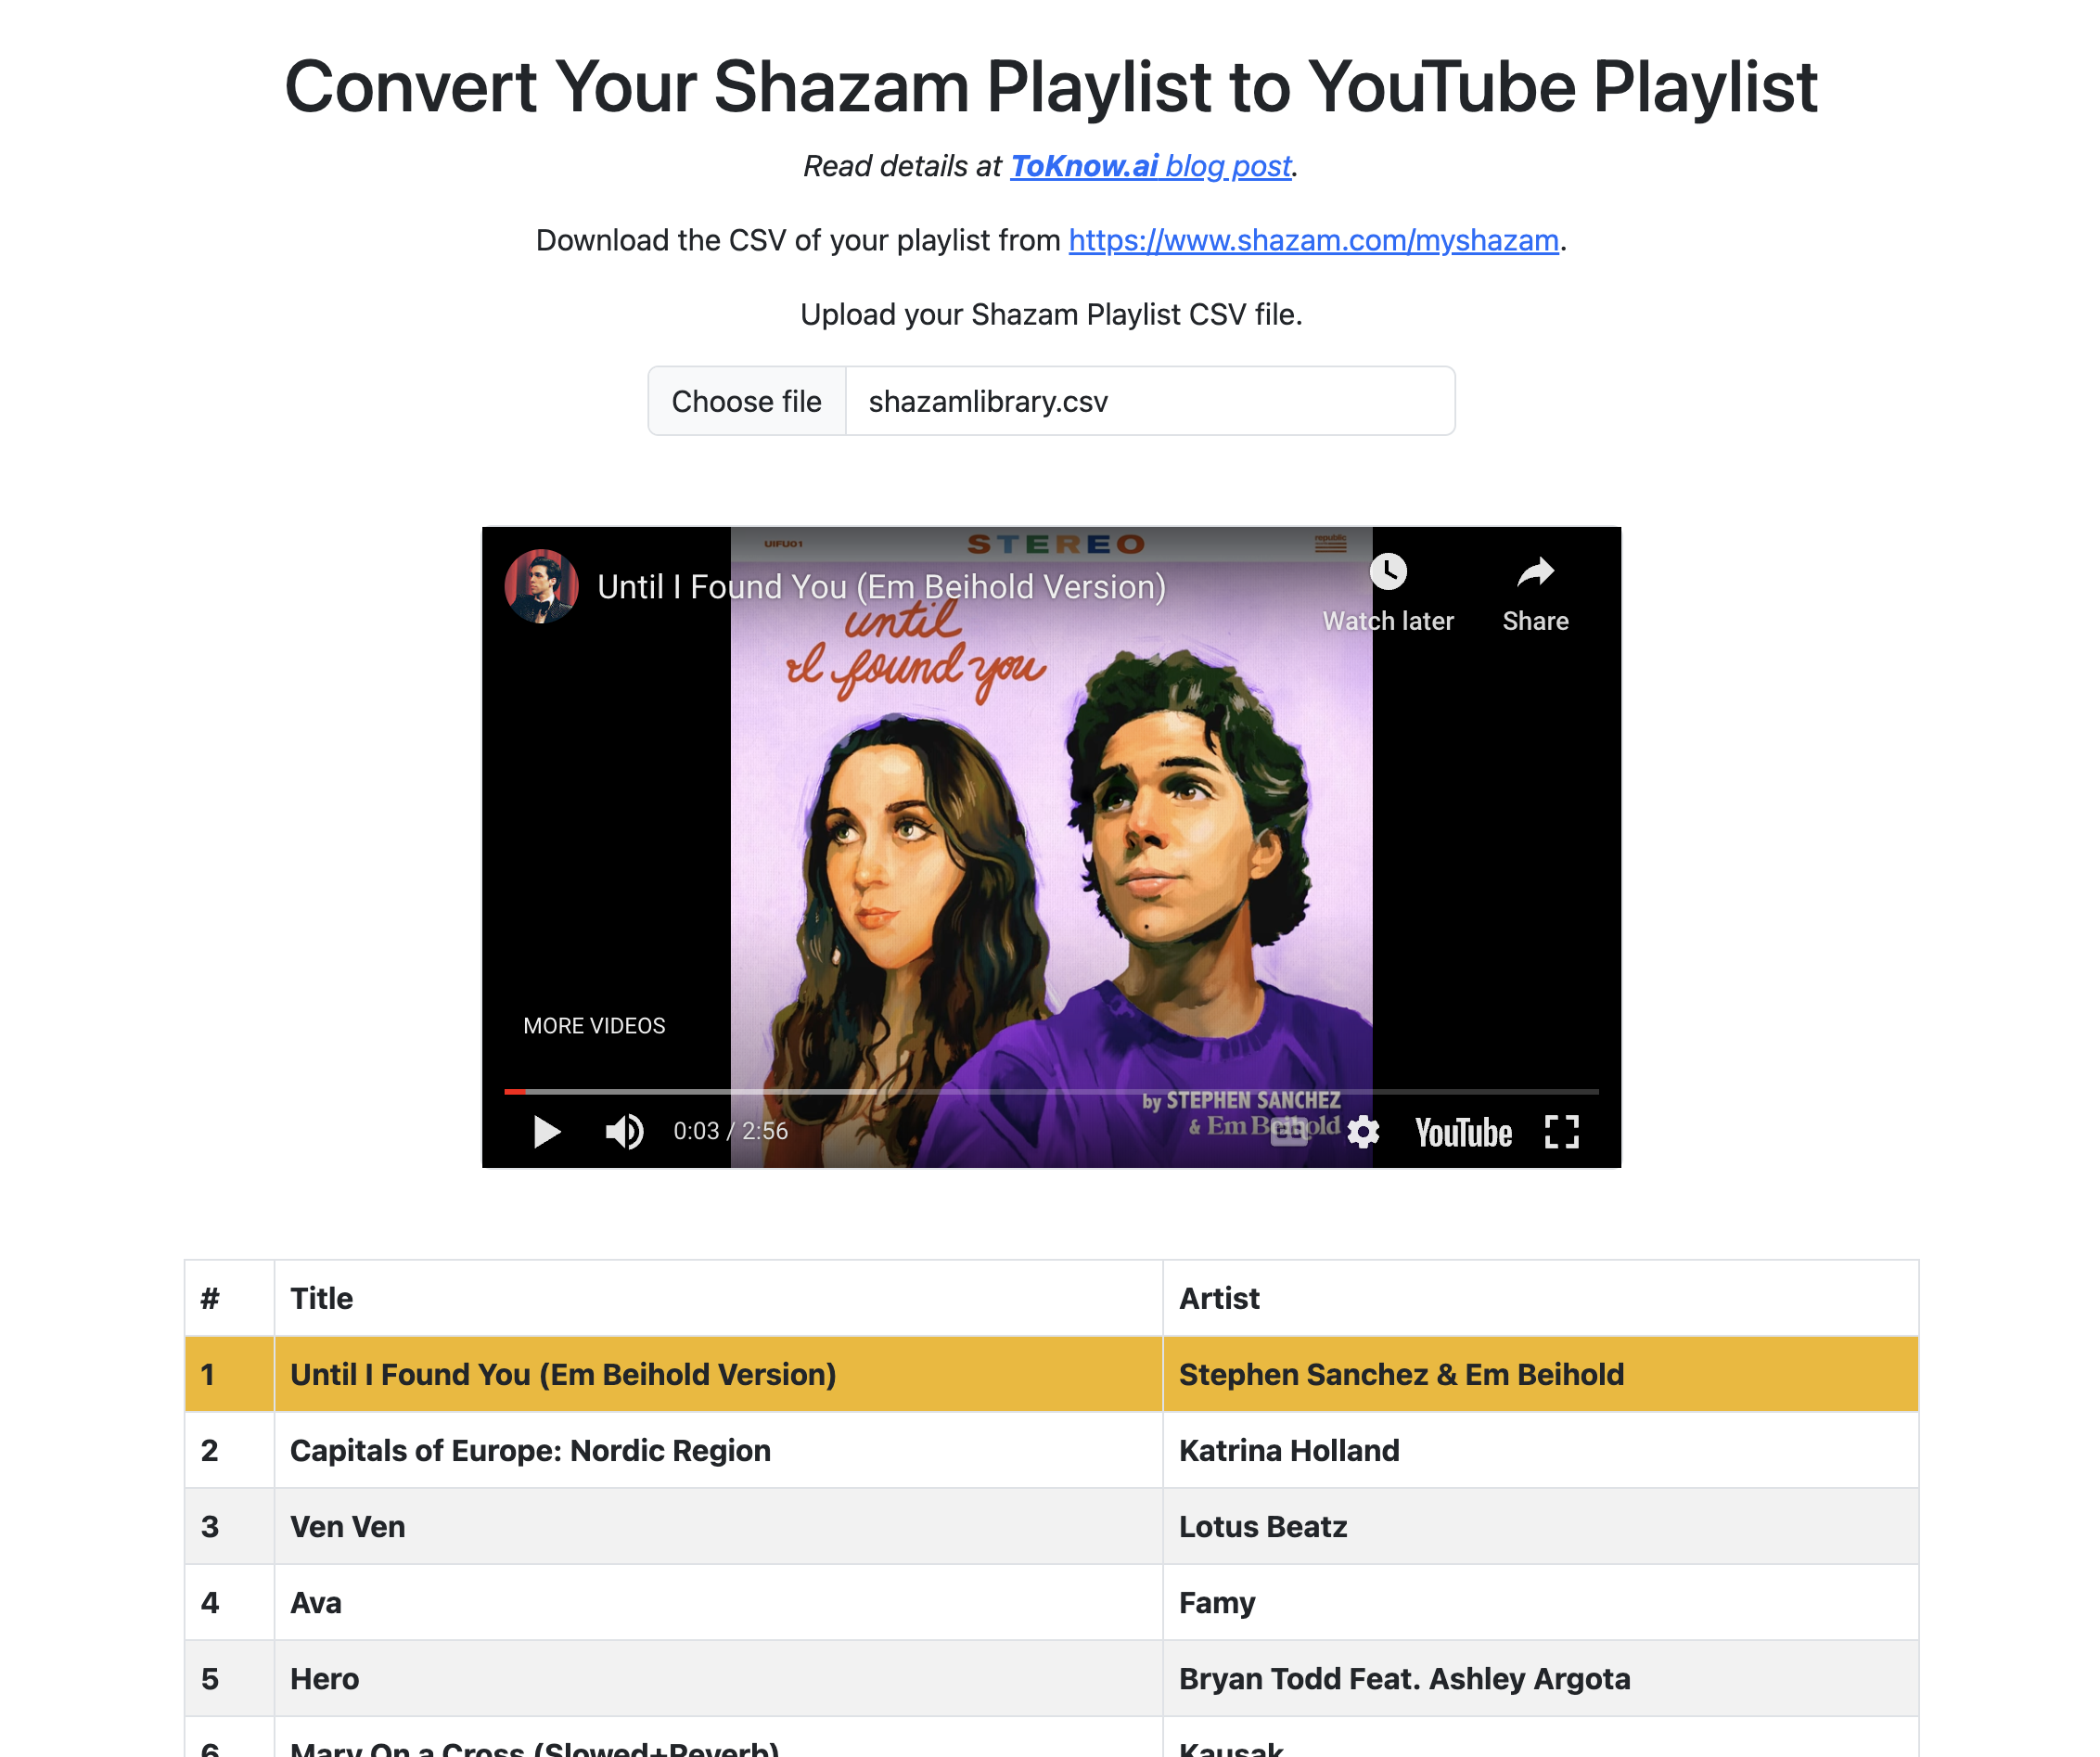
<figcaption aria-hidden="true">Test the app below this page</figcaption>
</figure>

## Introduction

Have you ever found yourself in a situation where you’ve Shazamed a
bunch of great songs, but can’t listen to them without subscribing to a
premium music service? Well, we’ve got great news for you! There’s a
free and easy way to enjoy your Shazam discoveries without breaking the
bank. Let’s dive into how you can convert your Shazam playlist to a
YouTube playlist and start listening right away.

## Enter the Shazam to YouTube Converter

We have developed a web application that takes your Shazam playlist and
converts it into a YouTube playlist. This means you can listen to full
versions of your discovered songs without paying for a subscription!

## How It Works

The process is surprisingly simple:

1.  **Export Your Shazam Library**: First, you’ll need to export your
    Shazam library as a CSV file. You can do this by visiting
    <https://www.shazam.com/myshazam> and downloading your list of
    identified songs.

2.  **Upload to the Converter**: Visit the [Shazam Playlist to YouTube
    Playlist
    converter](../../apps/shazam-playlist-to-youtube-playlist.qmd).
    Here, you’ll see an option to upload your CSV file.

3.  **Watch the Magic Happen**: Once you upload your file, the
    application processes your Shazam list and creates a YouTube
    playlist on the fly.

4.  **Start Listening**: A YouTube player will appear, ready to play
    through your entire list of songs. You can also see a table of all
    your tracks, allowing you to easily jump to any song in the list.

## Code

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./shazam-playlist-to-youtube-playlist")

In [2]:
from IPython.display import HTML
import pandas as pd
from pytube import YouTube
from app import get_youtube_song

### Preview Data

In [3]:
# Load the Shazam library from a CSV file and return the DataFrame.
shazamlibrary_df = pd.read_csv('shazamlibrary.csv', header=1)
shazamlibrary_df

227 rows × 6 columns

### Format data

In [4]:
# Remove Duplicates and Select `Title` and `Artist`.
shazamlibrary_df = shazamlibrary_df.drop_duplicates(subset=['TrackKey'])[['Title', 'Artist']]
shazamlibrary_df

201 rows × 2 columns

In [5]:
# Test search
search_title, search_artist = shazamlibrary_df.loc[0].values
youtube: YouTube = get_youtube_song(search_title, search_artist)
youtube.watch_url

'https://youtube.com/watch?v=kPlSyYtE63M'

### Code to run the player

Below is the code used to run the server at Huggingface:

``` python
"""Shazam Playlist to Youtube Playlist"""

from typing import Optional
import logging
import pandas as pd
from pytube import Search, YouTube
from flask import Flask, request, send_from_directory

# https://github.com/pytube/pytube/issues/1270#issuecomment-2100372834
pytube_logger = logging.getLogger('pytube')
pytube_logger.setLevel(logging.ERROR)

app = Flask(__name__)

@app.route('/')
def index():
    """Route handler for the home page"""
    try:
        return send_from_directory('.', 'index.html')
    except Exception as e:
        return str(e)
    
@app.route('/video_id', methods=['POST'])
def video_id() -> str:
    """Route handler for retrieving the YouTube video ID"""
    try:
        title: str = request.json.get('title')
        artist: str = request.json.get('artist')
        youtube: YouTube = get_youtube_song(title, artist)
        return youtube.video_id
    except Exception as e:
        return str(e)

@app.route('/parse_csv', methods=['POST'])
def parse_csv():
    """Route handler for parsing the uploaded CSV file"""
    try:
        file = request.files['file']
        # Process the uploaded file
        shazamlibrary_df = pd.read_csv(file, header=1)
        shazamlibrary_df = shazamlibrary_df.drop_duplicates(subset=['TrackKey'])[['Title', 'Artist']]
        return shazamlibrary_df.to_json(orient="records")
    except Exception as e:
        return str(e)

def get_youtube_song(title: str, artist: str) -> Optional[YouTube]:
    """Searches for a YouTube video based on the given title and artist"""
    search_result = Search(f'{title} by {artist}')
    return search_result.results[0] if search_result.results else None
```

Below is the HTML page that renders the page:

``` html
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>ToKnow.ai - Shazam Playlist to Youtube Playlist</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/js/bootstrap.bundle.min.js"></script>
    <script src="https://www.youtube.com/iframe_api"></script>
    <style>
        .youtube-player,
        iframe {
            width: 100%;
            height: 100%;
        }

        .playlist tbody tr {
            cursor: pointer;
        }
    </style>
</head>

<body>
    <div class="container my-4">
        <h1 class="text-center">Convert Your Shazam Playlist to YouTube Playlist</h1>
        <p class="text-center">
            <em>
                <i>
                    Read details or <b>Comment</b> at
                    <a target="_blank"
                        href="https://toknow.ai/posts/shazam-playlist-to-youtube-playlist/"><b>ToKnow.ai</b> blog
                        post.
                    </a>
                </i>
            </em>
        </p>
        <p class="text-center">
            Download the CSV of your playlist from
            <a href="https://www.shazam.com/myshazam" target="_blank">https://www.shazam.com/myshazam</a>.
        </p>
        <p class="text-center">Upload your Shazam Playlist CSV file.</p>
        <div class="row mx-2 justify-content-center">
            <div class="col-md-6">
                <input type="file" class="form-control upload-form col-md-6" accept=".csv">
            </div>
        </div>

        <div class="row mt-5 justify-content-center">
            <div class="col-md-8">
                <div class="object-fit-contain border rounded ratio ratio-16x9">
                    <div class="youtube-player"></div>
                </div>
            </div>
        </div>

        <div class="row mt-5">
            <div class="col-md-12 playlist table-responsive">
            </div>
        </div>
    </div>

    <script>
        const playlistTable = document.querySelector('.playlist');
        const uploaForm = document.querySelector('.upload-form');
        let songsPlaylist = []
        let videoIndex = -1;
        let youtubePlayer;

        uploaForm.addEventListener('input', e => {
            e.preventDefault();
            if (e.target.files.length == 0) {
                return;
            }

            parseCsv(e.target.files[0], playlistTable);
        });
        playlistTable.addEventListener('click', e => {
            e.preventDefault();
            const row = event.target.closest('tr');
            if (row) {
                const index = row.dataset.index ? Number(row.dataset.index) : undefined;
                onContinue(undefined, index);
            }
        });
        function resetCurrentPlayingBackground() {
            playlistTable.querySelectorAll('tbody tr').forEach(row => {
                if (Number(row.dataset.index) == videoIndex) {
                    row.classList.add('bg-warning');
                } else {
                    row.classList.remove('bg-warning');
                }
            })
        }
        function addErrorToCurrentIndex() {
            playlistTable.querySelectorAll('tbody tr').forEach(row => {
                if (Number(row.dataset.index) == videoIndex) {
                    row.classList.add('bg-danger');
                }
            })
        }
        async function getVideoId(song) {
            const response = await fetch(
                '/video_id',
                {
                    headers: { 'Content-Type': 'application/json' },
                    method: 'POST',
                    body: JSON.stringify({ title: song.Title, artist: song.Artist })
                });
            return await response.text()
        }
        async function nextVideo(callback, newIndex = undefined) {
            newIndex = newIndex >= 0 ? newIndex : (videoIndex + 1)
            videoIndex = newIndex < songsPlaylist.length ? newIndex : 0;
            let video_id = await getVideoId(songsPlaylist[videoIndex]);
            callback(video_id);
            resetCurrentPlayingBackground();
        }
        async function parseCsv(file, playlistTable) {
            try {
                const formData = new FormData();
                formData.append('file', file);
                songsPlaylist = await (await fetch('/parse_csv', { method: 'POST', body: formData })).json();

                tableBody = songsPlaylist.map((i, index) => `
                                <tr data-index="${index}">
                                    <th>${index + 1}</th>
                                    <th>${i.Title}</th>
                                    <th>${i.Artist}</th>
                                </tr>`
                ).join('')
                playlistTable.innerHTML = `
                    <table class="table table-striped table-hover table-bordered rounded">
                        <thead>
                            <tr>
                                <th>#</th>
                                <th>Title</th>
                                <th>Artist</th>
                            </tr>
                        </thead>
                        <tbody>${tableBody}</tbody>
                    </table>`
            } catch (error) {
                playlistTable.innerHTML = error;
            }
        }
        function initiatePlayer() {
            const youtubePlayerElement = document.querySelector('.youtube-player');
            youtubePlayer = window.youtubePlayer = new YT.Player(youtubePlayerElement, {
                height: '100%',
                width: '100%',
                playerVars: { autoplay: 1 },
                events: {
                    'onReady': function (event) {
                        event.target.playVideo()
                    },
                    'onStateChange': function (event) {
                        if (event.data === YT.PlayerState.ENDED) {
                            onContinue(event?.target);
                        }
                    },
                    'onError': function (event) {
                        addErrorToCurrentIndex();
                        onContinue(event?.target);
                    }
                }
            });
        }
        function onContinue(player = undefined, newIndex = undefined) {
            if (songsPlaylist.length > 0) {
                nextVideo((value) => {
                    player = player || youtubePlayer
                    player.loadVideoById(value);
                    setTimeout(() => {
                        player.playVideo();

                        setTimeout(() => {
                            if (player.getPlayerState() != YT.PlayerState.PLAYING) {
                                player.playVideo();
                            }
                        }, 10);
                    }, 10);
                }, newIndex);
            }
        }
        const setIntervalId = setInterval(() => {
            if (YT.Player) {
                if (!youtubePlayer) {
                    initiatePlayer();
                } else if (songsPlaylist.length > 0) {
                    clearInterval(setIntervalId);
                    onContinue();
                }
            }
        }, 300);
    </script>
</body>

</html>
```

## Test the App

> [/apps/shazam-playlist-to-youtube-playlist](../../apps/shazam-playlist-to-youtube-playlist.qmd)

In [6]:
HTML('''<iframe
    src="https://toknow-ai-shazam-playlist-to-youtube-playlist.hf.space"
    frameborder="0"
    width="100%"
    height="600"
    style="width:100%"
></iframe>''')

## Conclusion

The Shazam to YouTube Playlist converter offers a fantastic, free
alternative for enjoying your music discoveries. It bridges the gap
between Shazam’s identification capabilities and the vast library of
music available on YouTube. Whether you’re a casual music listener or an
avid discoverer of new tunes, this tool provides a valuable service
without the need for paid subscriptions. Give it a try and turn your
Shazam discoveries into a personalized YouTube concert. Happy listening!

------------------------------------------------------------------------

***Disclaimer:*** *This publication is meant for informational purposes
only. We do not guarantee accuracy or completeness. We do not encourage
illegal or malicious use.* *While this tool is free and convenient,
always respect copyright laws and support your favorite artists when
possible.* ***Read more:
[/terms-of-service](https://toknow.ai/terms-of-service)***